In [1]:
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from sklearn.metrics import classification_report
import numpy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
img_width, img_height = 64, 64

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/chest_xray/train',
                                                 target_size = (img_width, img_height),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 5230 images belonging to 2 classes.


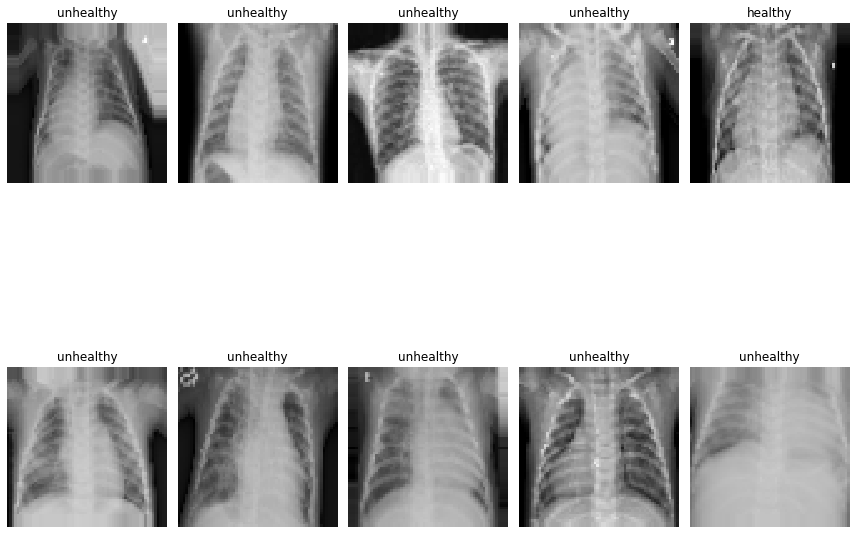

In [4]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in training_set:
        image = X_batch[0]        
        dic = {1:'unhealthy', 0:'healthy'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [5]:
from collections import Counter


In [6]:
cases_count = Counter(training_set.classes)
print(cases_count.items())

dict_items([(0, 1355), (1, 3875)])


In [7]:
total = cases_count[0] + cases_count[1]
weight_for_0 = (1 / cases_count[0]) * (total / 2.0)
weight_for_1 = (1 / cases_count[1]) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
print(class_weight)

{0: 1.9298892988929888, 1: 0.6748387096774194}


In [8]:
val_datagen = ImageDataGenerator(rescale = 1./255)
val_set = val_datagen.flow_from_directory('/content/drive/MyDrive/chest_xray/val',
                                            target_size = (img_width, img_height),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 16 images belonging to 2 classes.


In [9]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/chest_xray/test',
                                            target_size = (img_width, img_height),
                                            batch_size = 32,
                                            class_mode = 'binary',
                                            shuffle=False)

Found 624 images belonging to 2 classes.


In [10]:
cnn = tf.keras.Sequential()


In [11]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[img_width, img_height, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [12]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 32)         0

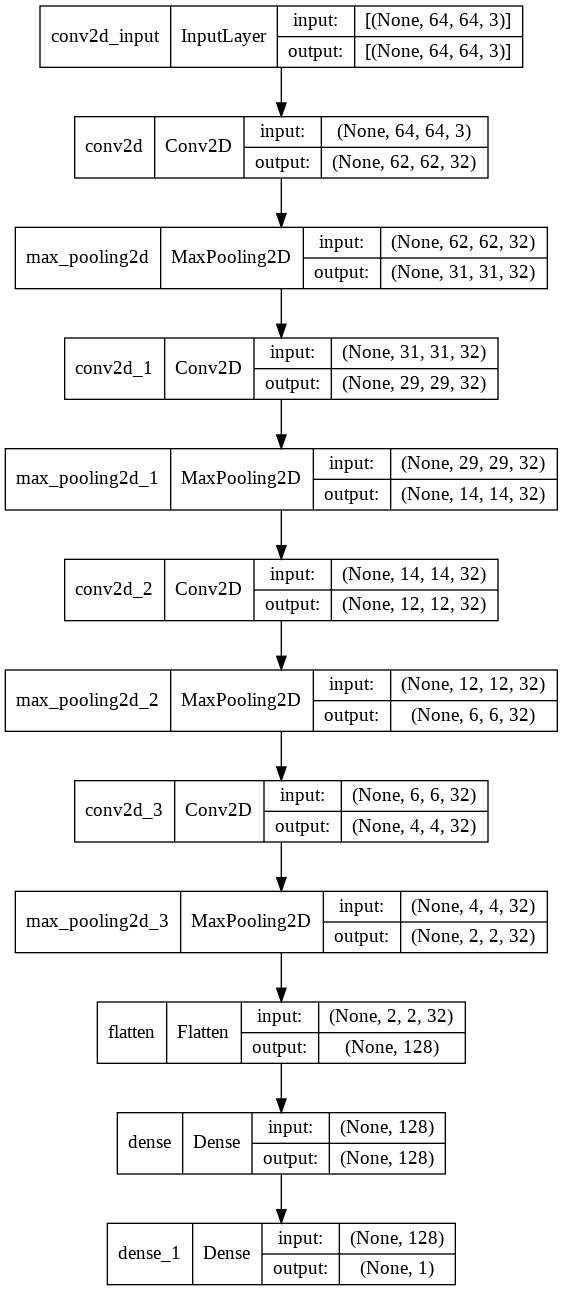

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [14]:
model_fit = cnn.fit(x = training_set, validation_data = val_set, epochs = 25, class_weight=class_weight)


Epoch 1/25
164/164 [==============================] - 867s 5s/step - loss: 0.4662 - accuracy: 0.7159 - val_loss: 0.6427 - val_accuracy: 0.6875
Epoch 2/25
164/164 [==============================] - 71s 431ms/step - loss: 0.2702 - accuracy: 0.8880 - val_loss: 0.4610 - val_accuracy: 0.7500
Epoch 3/25
164/164 [==============================] - 71s 433ms/step - loss: 0.2280 - accuracy: 0.9099 - val_loss: 0.5725 - val_accuracy: 0.5625
Epoch 4/25
164/164 [==============================] - 71s 432ms/step - loss: 0.1982 - accuracy: 0.9231 - val_loss: 0.7917 - val_accuracy: 0.6250
Epoch 5/25
164/164 [==============================] - 71s 434ms/step - loss: 0.2022 - accuracy: 0.9205 - val_loss: 0.4212 - val_accuracy: 0.6875
Epoch 6/25
164/164 [==============================] - 72s 436ms/step - loss: 0.1814 - accuracy: 0.9308 - val_loss: 0.3146 - val_accuracy: 0.8125
Epoch 7/25
164/164 [==============================] - 74s 450ms/step - loss: 0.1729 - accuracy: 0.9359 - val_loss: 0.3134 - val_accu

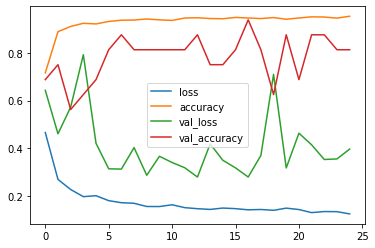

In [15]:
import pandas as pd

pd.DataFrame(cnn.history.history).plot()

In [16]:
model_evaluation = cnn.evaluate(test_set)


20/20 [==============================] - 109s 6s/step - loss: 0.2193 - accuracy: 0.9199


In [17]:
preds = np.round(cnn.predict(test_set),0)

In [18]:
gt_class = test_set.classes
gt_labels = list(test_set.class_indices.keys())

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score

In [20]:
cm = confusion_matrix(gt_class, preds)
print(cm)
print('The cnn model has an accuracy score of {:.2f} and recall score of {:.2f} for {:s}'.format((accuracy_score(gt_class, preds) *100),(recall_score(gt_class, preds) *100),gt_labels[1]))

[[190  44]
 [  6 384]]
The cnn model has an accuracy score of 91.99 and recall score of 98.46 for PNEUMONIA


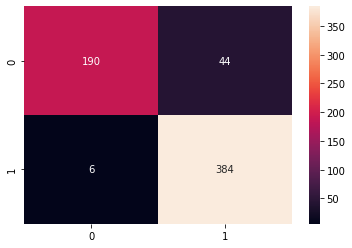

In [21]:
import seaborn as sns
sns.heatmap(cm, annot =True, fmt="d")

In [22]:
report = classification_report(gt_class, preds, target_names=gt_labels)
print(report)

              precision    recall  f1-score   support

      NORMAL       0.97      0.81      0.88       234
   PNEUMONIA       0.90      0.98      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.90      0.91       624
weighted avg       0.92      0.92      0.92       624



(624, 64, 64, 3)
(624,)


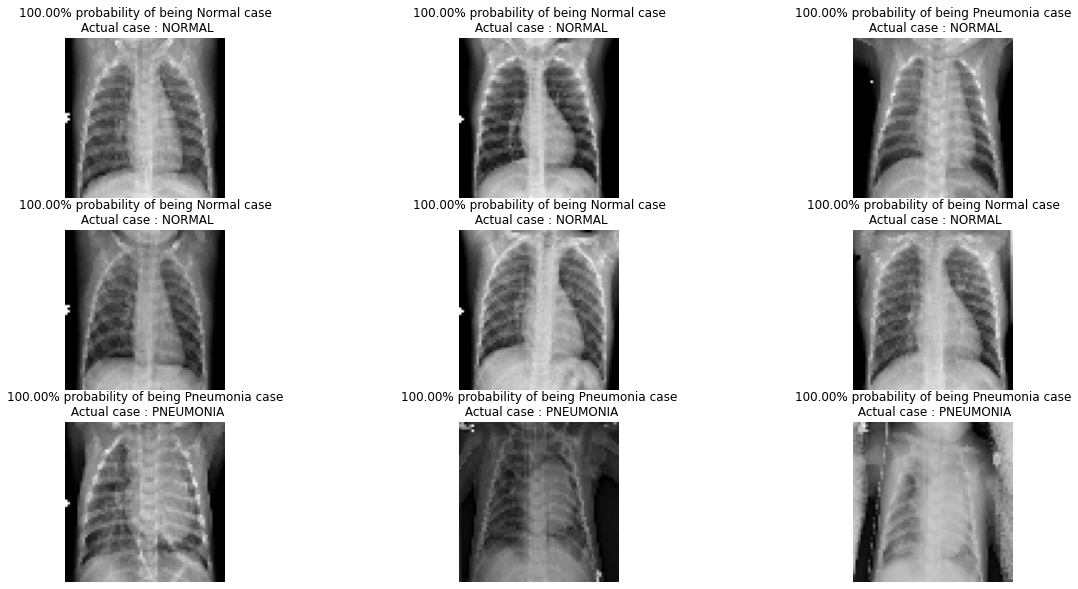

In [23]:
test_set.reset()
x=np.concatenate([test_set.next()[0] for i in range(test_set.__len__())])
y=np.concatenate([test_set.next()[1] for i in range(test_set.__len__())])
print(x.shape)
print(y.shape)
#this little code above extracts the images from test Data iterator without shuffling the sequence
# x contains image array and y has labels 
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,10))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))
      
      
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
  plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()

In [25]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [26]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(gt_class, preds)

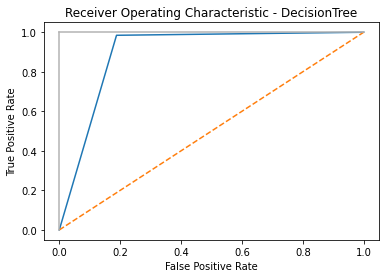

In [27]:
plt.title('Receiver Operating Characteristic - DecisionTree')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()